In [12]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data

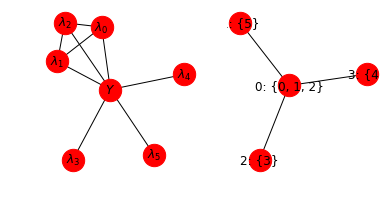

In [13]:
M = 6
N = 1000 #not used
MAX_CLIQUE_SIZE = 3
NUM_CLIQUES = 1
K = 2
HIGHER_ORDER_CLIQUES = False

# Set Graph Structure
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()


#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

#get true values for later comparison, label model
sigma_O = data.get_sigma_O()
class_balance = data.get_class_balance()

## Visualize Inverse Sigma_O

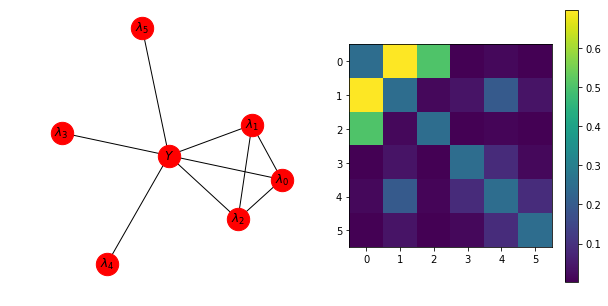

In [14]:
sigma_O = data.get_sigma_O()
E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
class_balance = data.get_class_balance()

plt.figure(figsize=(10,5))
sigma_O_clean = np.zeros(np.shape(sigma_O))

sigma_O_clean = np.abs(np.linalg.inv(sigma_O))
for i in range(np.shape(sigma_O)[0]):
    sigma_O_clean[i,i] = 0.0

plt.subplot(1,2,1)
deps_graph.draw()

plt.subplot(1,2,2)
plt.imshow(sigma_O_clean)
plt.colorbar()